**(Run this cell to define useful Latex macros)**
\\[
\newcommand{\card}[1]{\left\lvert#1\right\rvert}
\newcommand{\condbar}[0]{\,\big|\,}
\newcommand{\eprob}[1]{\widehat{\text{Pr}}\left[#1\right]}
\newcommand{\fpartial}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ffpartial}[2]{\frac{\partial^2 #1}{\partial {#2}^2}}
\newcommand{\gradient}[0]{\nabla}
\newcommand{\norm}[1]{\left\lvert\left\lvert#1\right\rvert\right\rvert}
\newcommand{\prob}[1]{\text{Pr}\left[#1\right]}
\newcommand{\pprob}[2]{\text{Pr}_{#1}\left[#2\right]}
\newcommand{\set}[1]{\left\{#1\right\}}
\newcommand{\trans}[1]{#1^\mathsf{T}}
\\]

# Lecture 00: Linear Regression

Regression is the task of predicting an unknown scalar continuous $y$ value from a known set of $x$ values. An example would be: what is the expected life-expectency of a human if you know their height? Here life-expectency in years would be the $y$ value and height in centimeters could be the $x$ value.

Regression is the task of learning a function $f$ such that $f(x)$ is the best guess of the life-expectency for an individual with height $x$.

*Linear* regression constrains the problem so that we only consider linear functions $f$ of $x$. That is:

\\[
f(x) = ax + b
\\]

So learning the best $f$ means finding the best values $a$ and $b$.

What does "best" mean? How do we find the "best" values of $a$ and $b$?

First, we need *training data*. In order to predict how long I will live since I am 185cm tall, you need a database of past people, where you knew their height and how long they lived. Using past data to formulate a *model* that lets you make good predictions for the future is called *learning*.

Since we're going to computerize the learning process, we call the field *machine learning*.

So let's say I have a database of old observed $x$ values and corresponding observed $y$ values. How do I use that to find a good model that I can use in the future?

To start, now that we have some past data, we can formulate a notion of "best." We will say that a good model does a good job of predicting the old, observed $y$ values from the old, observed $x$ values. Basically: in order to believe that a model will do a good job of predicting the future, it should have done a good job of predicting the past.

We will not expect our model to predict the past *perfectly*. That would be unreasonable. For instance, you can't perfectly predict someone's life expectency from their height, because there are so many other factors that effect how long an individual will live. For instance, do they smoke? We apparently don't have access to that information; we've got to do the best we can with the limited, partial information we do have.

Let's get more specific. Say we have a 100cm person in our dataset, and they lived to be 75 years old. Let say we are considering a proposed model $f(x) = \frac{x}{10} + 50$. We can check that $f(100) = \frac{100}{10} + 50 = 60$. So we are 15 years off (too low) in predicting this persons life expectency.

Let's say the person had lived for 50 years instead. Then we would have been 10 years off (too high).

In general, the error for the $i$-th example in our dataset is:

\\[
\left|y^{(i)} - f(x^{(i)})\right|
\\]

The superscript $(i)$ means that $i$-th $y$ value, $i$-th $x$ value. This is the error on a single example in our dataset. The goodness of a model isn't about its error on just one example in the dataset; it should be about the overall error across the all the examples.

Thus, one possible error function is:

\\[
\frac{1}{N} \sum_{i = 1}^N \left|y^{(i)} - f(x^{(i)})\right|
\\]

This is called the *mean absolute error*.

Let's start to try to make things a little more real. First, let's generate a fake dataset.

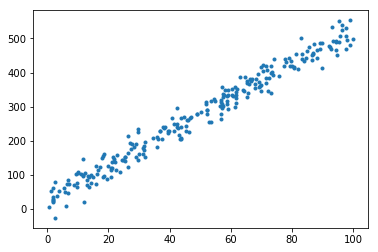

In [66]:
%matplotlib inline

import numpy as np

# So that we reliably generate the same random numbers.
np.random.seed(0)

NUM_DATAPOINTS = 250
# 1000 random x values in the range 0 to 100.
x_values = np.random.uniform(size = NUM_DATAPOINTS) * 100

TRUE_SLOPE = 5.0
TRUE_INTERCEPT = 30.0
def true_relationship(x):
    return TRUE_SLOPE * x + TRUE_INTERCEPT

y_values = true_relationship(x_values)
# Add some "jitter". Some effects from random factors.
STDDEV = 25.0
noise = STDDEV * np.random.normal(size = NUM_DATAPOINTS)
y_values += noise

import matplotlib.pyplot as plt

plt.plot(x_values, y_values, '.')

I'm using two libraries here: numpy as matplotlib. I will use these both *a lot*.

Look at some matplotlib tutorials. Here are two:

* https://www.labri.fr/perso/nrougier/teaching/matplotlib/
* https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python

I'm not a matplot wizard, so I'll mostly do simple stuff.

The other library I'll use a ton is numpy. You should look at tutorials for that too:

* https://www.datacamp.com/community/tutorials/python-numpy-tutorial
* http://cs231n.github.io/python-numpy-tutorial/

Let's keep looking at our data. Let's plot the "true" model line; which is how we calculated the $y$ values from the $x$ values, before we added in the random jitter. Let's also calculate the mean absolute error using the true model.

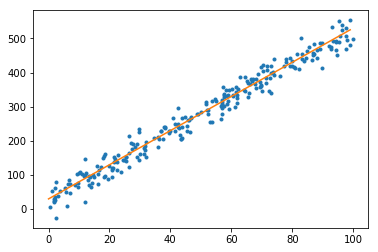

MAE: 18.907769136659283
MAE: 18.90776913665929


In [67]:
plt.plot(x_values, y_values, '.')
plt.plot(np.arange(100), TRUE_SLOPE * np.arange(100) + TRUE_INTERCEPT, '-')
plt.show()

dataset_error = 0
for x, y in zip(x_values, y_values):
    datapoint_error = np.abs(y - (TRUE_SLOPE * x + TRUE_INTERCEPT))
    dataset_error += datapoint_error
dataset_error = dataset_error / NUM_DATAPOINTS

print(f'MAE: {dataset_error}')

# Equivalent, faster, more concise.
errors = np.abs(y_values - (TRUE_SLOPE * x_values + TRUE_INTERCEPT))
dataset_error = np.sum(errors) / NUM_DATAPOINTS
print(f'MAE: {dataset_error}')

Great. We see that the MAE is 21.35. As expected, our model cannot perfectly predict the $y$ values from the $x$ values.

Now, what if we didn't know `TRUE_SLOPE` and `TRUE_INTERCEPT`? That's the typical setup: that's why we have to *learn*. How would we find the best line? We will use *gradient descent*. Gradient descent is used all the time for neural networks. But before we talk about it, I want to change my choice of *loss function* from mean absolute error to *mean squared error*. Let me show you:

\\[
\frac{1}{N} \sum_{i = 0}^N \left(y^{(i)} - f(x^{(i)}\right)^2
\\]

Why would I prefer this function? The primary reason for right now is that this function is *smoothly differentiable*. Gradient descent works by using derivatives. Let's see what smoothly differentiable means:

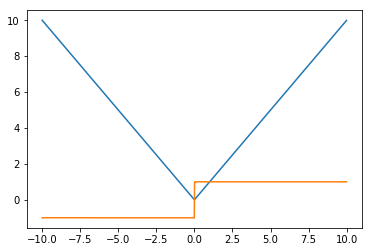

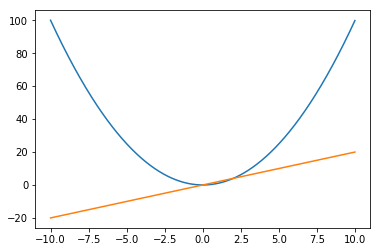

In [68]:
plt.plot(np.arange(-10, 10, 0.01), np.abs(np.arange(-10, 10, 0.01)), '-')
plt.plot(
    np.arange(-10, 10, 0.01),
    np.abs(np.arange(-10, 10, 0.01)) / (np.arange(-10, 10, 0.01) + 0.0001),
    '-'
)
plt.show()

plt.plot(np.arange(-10, 10, 0.01), np.arange(-10, 10, 0.01) ** 2, '-')
plt.plot(
    np.arange(-10, 10, 0.01),
    2 * np.arange(-10, 10, 0.01),
    '-'
)
plt.show()


In the above diagrams, the blue graphs are graphs of the error as a function of `y - f(x)`. The thing to note is that for the absolute error diagram, increasing `y - f(x)` is a good thing, until we get to `y - f(x) = 0`, at which point it flips discontinuously to a bad thing.

For the squared error diagram, we see a smooth transition from "increasing `y - f(x)` is good" to "increasing `y - f(x)` is bad."

Let's look at our mean squared error function again. Let's expand it to be in terms of $a, b$, a slope and intercept. These are called the *parameters* of our model. To find the best model, we need to find the best parameters.

\\[
\begin{align}
    \frac{1}{N} \sum_{i = 0}^N \left(y^{(i)} - f(x^{(i)}\right)^2
&=
    \frac{1}{N} \sum_{i = 0}^N \left(y^{(i)} - (ax^{(i)} + b)\right)^2
\\
&=
    \frac{1}{N} \sum_{i = 0}^N (y^{(i)})^2 - 2 y^{(i)} (ax^{(i)} + b) + (ax^{(i)} + b)^2
\\
&=
    \frac{1}{N} \sum_{i = 0}^N (y^{(i)})^2 - 2 y^{(i)} (ax^{(i)} + b) + a^2(x^{(i)})^2 + 2 ax^{(i)} + b^2
\end{align}
\\]

Okay, I don't want to expand this formula any more. Can you see that it is quadratic *as a function of $a, b$*? That is: the highest power of $a$ and $b$ involved is squaring.

Let's graph the error function as a function of just $a$ given a fixed $b$. For my fixed $b$ I'll just use the true intercept.

TRUE MODEL STDDEV: 23.95


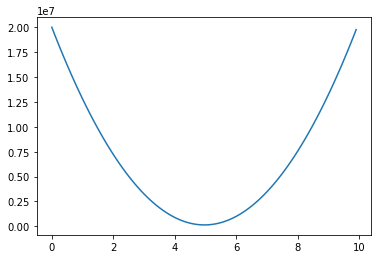

In [75]:
def squared_error(x_values, y_values, a, b):
    yhat = (a * x_values + b)
    return np.sum((y_values - yhat) ** 2)

true_mse = (1 / len(x_values)) * squared_error(x_values, y_values, TRUE_SLOPE, TRUE_INTERCEPT)
print(f'TRUE MODEL STDDEV: {np.sqrt(true_mse):0.2f}')

slopes = np.arange(0, 10, 0.1)
errors = [squared_error(x_values, y_values, a, TRUE_INTERCEPT) for a in slopes]

plt.plot(slopes, errors, '-')

Just like I promised you, this is a quadratic function. Notice that it obtains a minimum between 5 and 6. That means the best slope for $b = 30$ is between 5 and 6.

Okay, now we need our calculus. A quadratic function is continuously differentiable. A continuously differentiable function has local minima where the derivative is zero.

My analysis here has been for a fixed $b$. But if you treat the error function as a function of two variables $a, b$, this is just a multidimensional minimization problem. You still have a continuously differentiable error function. So you know that the partial derivatives with respect to *both* $a$ and $b$ should be zero:

\\[
\fpartial{E(a, b)}{a} = 0
\\
\fpartial{E(a, b)}{b} = 0
\\]

Now, for linear models it is possible to compute the $a, b$ that exactly achieve this. That is, I could give you a formula for the exact $a, b$ pair that are the best at minimizing $E(a, b)$.

**Optional** If you really love linear algebra, I'll show you. But you don't need to know this.

\\[
(a, b) = (\trans{X}X)^{-1} \trans{X}y
\\]

Here $X$ is the data matrix, which in this version has two columns: the first are the $x$ values, and the second column is just all ones (for the intercept). $y$ is a column vector of the $y$ values in the dataset.

You can find a derivation here: https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics)#Derivation_of_the_normal_equations

This approach works fine for *linear* models. But we're going to explore neural networks, and neural networks are nonlinear, which is what allows them to learn complex models. So this approach won't work forever.

The other problem is that this approach requires you to invert $(\trans{X}X)^{-1}$. That is: invert the correlation matrix. In the future, if you have a very large number of $x$ dimensions (like height, weight, IQ, et cetera), then finding the inverse of the matrix of correlations of the $x$s is going to be $O(n^3)$. So this approach is not *scalable*. It is also hard to parallelize across many computers.

**Not optional**: Did you tune out for the linear algebra? Good. Now I need to tell you the part that you *do* need to know :-)

I don't care about finding a "closed form" formula for $a$ and $b$. I will content myself with an *iterative process* (that is: an algorithm) that starts with a random choice for $a$ and $b$ and improves them step-by-step.

The problem of finding minima is called *optimization.* There are in general two major kinds of optimization methods: ones that use second derivatives, and those that only use first derivatives.

When we have a multidimensional $x$, this corresponds to methods that use *Hessians* (matrix of second derivatives) and *gradients* (vector of partial derivatives).

The classic second-order optimization algorithm is *Newton's method*. Newton's method for a 1-dimensional $x$ is very simple. First, say you start at $x_0$. Evaluate $\fpartial{f(x_0)}{x}$. You want this to be zero, since that is a critical point. However, at a random starting location, this is not zero.

You want to change $x_0$ to some $x_1 = x_0 + \Delta_0$ where $f(x_1) = 0$. How do we calculate or estimate $\Delta_0$? We assume that $\fpartial{f(x)}{x}$ is *linear*. In the case where $f$ is a quadratic polynomial, it *is* true that $\fpartial{f(x)}{x}$ is linear in $x$. In our linear least squares regression problem, our assumption is exactly true! But Newton's method is often very successful for optimization of non-quadratic functions.

How does it work? Well, first I ask: what do we want $\fpartial{f(x_1)}{x} - \fpartial{f(x_0)}{x}$ to be? We want it to be $-\fpartial{f(x_0)}{x}$, because that means exactly that $\fpartial{f(x_1)}{x} = 0$.

So, how much do we need to change $x_0$ to result in a change in slope of $-\fpartial{f(x_0)}{x}$? Well, that depends on how fast the slope is changing as we change $x$. And that is of course calculated by $\ffpartial{f(x)}{x}$, the *second* partial derivative.

Thus the change $\Delta_0$ should be:

\\[
\Delta_0 = -\fpartial{f(x_0)}{x} \big/ \ffpartial{f(x_0)}{x}
\\]

If the function $f$ truly has a linear second derivative, this $\Delta_0$ is exactly what we need. But if not, then the slope will be changing non-linearly, and $\Delta_0$ is based on a faulty assumption. So we may need to *repeat* the process. That's what makes Newton's method an *iterative* method.

The expectation is that the estimate of the optimal $x^*$ gets better and better, and that we can stop when $\fpartial{f(x_k)}{x}$ gets close enough to zero.

**Optional**: The multivariate analogue to this is:

\\[
\Delta_i = H^{-1}(- \gradient f(x_i))
\\]

where $H$ is the Hessian: the matrix of second partial derivatives. This says: you want to get to a zero gradient, so you want to change the gradient by $- \gradient f(x_i)$. The Hessian is telling you: if you change $x$ by $\Delta_i$, you will change the gradient by $H \Delta_i$. So what should $\Delta_i$ be to effect a change in gradient of $-\gradient f(x_i)$? Just as I said above.

Inverting matrices is $O(k^3)$, where $k$ is the number of dimensions. So it is very *not scalable* to take this approach.

**Not Optional**: A way that uses *no* second derivative is called *gradient descent*. It is an example of a first-order method. Generally first-order methods take more optimization steps to get to a good result, because they are using less information about the function $f$ than a second-order method. On the other hand, each step of a first-order method can be substantially faster to perform, since you do not need to compute as much information (e.g., matrix of partial derivatives).

Here's how gradient descent works: we just make a guess at the second derivative and use that for Newton's method, never calculating a second derivative ourselves. The "guess" is typically called a *learning rate*. The learning rate is an example of a hyperparameter: it isn't like $a, b$, which are parameters we're trying to learn which define our model. A hyperparameter is a "knob" that controls the learning process. The learning rate is typically the most important knob to try out adjusting. Finding a good learning rate is essential, or else gradient descent works poorly.

The learning rate (typically denoted $\lambda$) is like a guess of the *inverse* of a constant second derivive. Therefore, we can write:

\\[
\Delta_i = -\lambda \fpartial{f(x_i)}{x}
\\]

or in other words:

\\[
x_{i + 1} = x_i - \lambda \fpartial{f(x_i)}{x}
\\]

The idea is really very simple. If $\fpartial{f(x_i)}{x} > 0$, then increasing $x$ a little will tend to increase $f(x)$. So instead *decrease* $x$ a little. Everything is flipped if $\fpartial{f(x_i)}{x} < 0$.

Okay! Let's code this up! First we need to calculate the partial derivative of the error function with respect to the slope and intercept $a$ and $b$:

\\[
\begin{align}
    SSE(a, b)
&=
    \frac{1}{N} \sum_{i = 0}^N \left(y^{(i)} - (ax^{(i)} + b)\right)^2
\\
\Rightarrow
    \fpartial{SSE(a, b)}{a}
&=
    \frac{1}{N} \sum_{i = 0}^N 2\left(y^{(i)} - (ax^{(i)} + b)\right) (-x^{(i)})
\\
\Rightarrow
    \fpartial{SSE(a, b)}{b}
&=
    \frac{1}{N} \sum_{i = 0}^N 2\left(y^{(i)} - (ax^{(i)} + b)\right) (-1)
\end{align}
\\]

With this math behind us, it's time to optimize!

In [70]:
def deriv_wrt_a(x_values, y_values, a, b):
    errors = y_values - (a * x_values + b)
    return (1 / len(x_values)) * np.sum(-2 * errors * x_values)

def deriv_wrt_b(x_values, y_values, a, b):
    errors = y_values - (a * x_values + b)
    return (1 / len(x_values)) * np.sum(-2 * errors * 1)

LEARNING_RATE_A = 3e-5
LEARNING_RATE_B = 5e-2
a, b = 0.0, 0.0
for epoch_idx in range(1, 301):
    da = deriv_wrt_a(x_values, y_values, a, b)
    db = deriv_wrt_b(x_values, y_values, a, b)
    
    a -= LEARNING_RATE_A * da
    b -= LEARNING_RATE_B * db
    if epoch_idx % 10 == 0:
        std_dev = np.sqrt((1 / len(x_values)) * squared_error(x_values, y_values, a, b))
        print(f'E {epoch_idx:04d} | a: {a:.2f} | b: {b:.2f} | stddev {std_dev:0.2f}')

E 0010 | a: 3.78 | b: 87.79 | stddev 41.74
E 0020 | a: 4.09 | b: 81.54 | stddev 35.95
E 0030 | a: 4.24 | b: 73.14 | stddev 32.84
E 0040 | a: 4.36 | b: 65.97 | stddev 30.46
E 0050 | a: 4.46 | b: 59.94 | stddev 28.67
E 0060 | a: 4.55 | b: 54.88 | stddev 27.33
E 0070 | a: 4.62 | b: 50.64 | stddev 26.35
E 0080 | a: 4.68 | b: 47.07 | stddev 25.64
E 0090 | a: 4.73 | b: 44.08 | stddev 25.12
E 0100 | a: 4.77 | b: 41.57 | stddev 24.75
E 0110 | a: 4.80 | b: 39.47 | stddev 24.49
E 0120 | a: 4.83 | b: 37.70 | stddev 24.30
E 0130 | a: 4.86 | b: 36.21 | stddev 24.17
E 0140 | a: 4.88 | b: 34.97 | stddev 24.08
E 0150 | a: 4.90 | b: 33.92 | stddev 24.01
E 0160 | a: 4.91 | b: 33.04 | stddev 23.96
E 0170 | a: 4.92 | b: 32.31 | stddev 23.93
E 0180 | a: 4.93 | b: 31.69 | stddev 23.91
E 0190 | a: 4.94 | b: 31.17 | stddev 23.89
E 0200 | a: 4.95 | b: 30.73 | stddev 23.88
E 0210 | a: 4.96 | b: 30.37 | stddev 23.87
E 0220 | a: 4.96 | b: 30.06 | stddev 23.87
E 0230 | a: 4.97 | b: 29.80 | stddev 23.86
E 0240 | a:

Each update step is called an *epoch*. Here you can see 300 steps of updates.

Okay! Look how accurate we got! Our estimates of $a, b$, which are denoted $\hat{a}, \hat{b}$ are almost exactly correct! But they're not quite accurate!

Notice that the standard deviation (the square root of the mean squared error) is 23.85. This is *lower* than the true model's standard deviation of 23.95. That is: we think the learned model is *better* than the true model!

This is called *overfitting*. Overfitting occurs when you think you can explain what really is in actuality random. Luckily, our overfitting here is pretty insignificant. Linear models tend to be very resistent to overfitting. Neural networks tend to be very prone to overfitting.

The two main things that can affect overfitting are (1) amount of training data and (2) complexity of the model we're trying to learn. More data reduces overfitting because spurious relationships that we think we learn are proven to be false by additional data. A more complex model increases overfitting because it has more *capacity* to try to explain randomness in the data.

If we had more data, we would expect the standard deviation to approach 25.0, since that is the standard deviation of the noise we added to the linearly calcualted $y$ values.


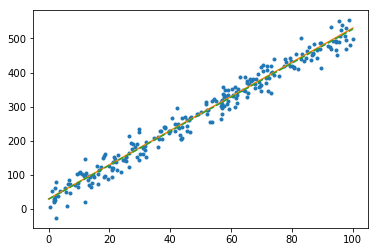

In [93]:
plt.plot(x_values, y_values, '.')
plt.plot(np.array([0, 100]), TRUE_SLOPE * np.array([0, 100]) + TRUE_INTERCEPT, '-')
plt.plot(np.array([0, 100]), a * np.array([0, 100]) + b, '--')